In [1]:
import pickle
from pathlib import Path
from typing import List, Optional, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandera as pa
import seaborn as sns
from pandera.typing import Category, DataFrame, Series
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier

mpl.style.use("fivethirtyeight")

# Initial Data Analysis


In [2]:
df = pd.read_csv("data/heart.csv")

In [3]:
df

,age,sex,chest pain type,resting blood pressure,chol,fasting blood sugar,resting ECG,max heart rate,exang,oldpeak,slope,number vessels flourosopy,thal,target
0,63,1,3,145,233,1,0,150.0,0,-99.99,0,0,1,1
1,37,1,2,130,250,0,1,187.0,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,NaN,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178.0,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163.0,1,0.60,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123.0,1,0.20,1,0,3,0
299,45,1,3,110,264,0,1,132.0,0,1.20,1,0,3,0
300,68,1,0,144,193,1,1,141.0,0,3.40,1,2,3,0
301,57,1,0,130,131,0,1,115.0,1,1.20,1,1,3,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        303 non-null    int64  
 1   sex                        303 non-null    int64  
 2   chest pain type            303 non-null    int64  
 3   resting blood pressure     303 non-null    int64  
 4   chol                       303 non-null    int64  
 5   fasting blood sugar        303 non-null    int64  
 6   resting ECG                303 non-null    int64  
 7   max heart rate             274 non-null    float64
 8   exang                      303 non-null    int64  
 9   oldpeak                    303 non-null    float64
 10  slope                      303 non-null    int64  
 11  number vessels flourosopy  303 non-null    int64  
 12  thal                       303 non-null    int64  
 13  target                     303 non-null    int64  

Only `max heart rate` has missing values.

Let's also check for duplicates.


In [5]:
print(f"Number of duplicates: {df.duplicated().sum()}")

Number of duplicates: 1


In [6]:
df[df.duplicated(keep=False)]

,age,sex,chest pain type,resting blood pressure,chol,fasting blood sugar,resting ECG,max heart rate,exang,oldpeak,slope,number vessels flourosopy,thal,target
163,38,1,2,138,175,0,1,173.0,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173.0,0,0.0,2,4,2,1


Probably a good idea to drop these duplicates when training and testing the model.

For a quick summary of the data:


In [7]:
df.describe()

,age,sex,chest pain type,resting blood pressure,chol,fasting blood sugar,resting ECG,max heart rate,exang,oldpeak,slope,number vessels flourosopy,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,274.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.978102,0.326733,-6.617723,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.767327,0.469794,26.828542,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,-99.990000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,136.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.600000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.750000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


The `oldpeak` seems to have some outliers/anomalies. After a quick search online for this feature, it seems that it should only have values greater than 0.0.

Let's check how many values are less than 0.0 and they're distribution.


In [8]:
print(f"Number of negative values for oldpeak: {len(df[df["oldpeak"] < 0])}")

Number of negative values for oldpeak: 23


In [9]:
df[df["oldpeak"] < 0]["oldpeak"].value_counts()

oldpeak
-99.99    23
Name: count, dtype: int64

For now, will leave as is, but will keep in mind for later.

Looking at the catagorical features:


In [10]:
categorical_feats = [
    "sex",
    "chest pain type",
    "fasting blood sugar",
    "resting ECG",
    "exang",
    "number vessels flourosopy",
    "slope",
    "thal",
]
for column in categorical_feats:
    print(f"Column: {column}")
    print(df[column].value_counts())
    print()

Column: sex
sex
1    207
0     96
Name: count, dtype: int64

Column: chest pain type
chest pain type
0    143
2     87
1     50
3     23
Name: count, dtype: int64

Column: fasting blood sugar
fasting blood sugar
0    258
1     45
Name: count, dtype: int64

Column: resting ECG
resting ECG
1    152
0    147
2      4
Name: count, dtype: int64

Column: exang
exang
0    204
1     99
Name: count, dtype: int64

Column: number vessels flourosopy
number vessels flourosopy
0    175
1     65
2     38
3     20
4      5
Name: count, dtype: int64

Column: slope
slope
2    142
1    140
0     21
Name: count, dtype: int64

Column: thal
thal
2    166
3    117
1     18
0      2
Name: count, dtype: int64



Let's also check if the target value is balanced.


In [11]:
df["target"].value_counts(normalize=True)

target
1    0.544554
0    0.455446
Name: proportion, dtype: float64

Visualising the data:


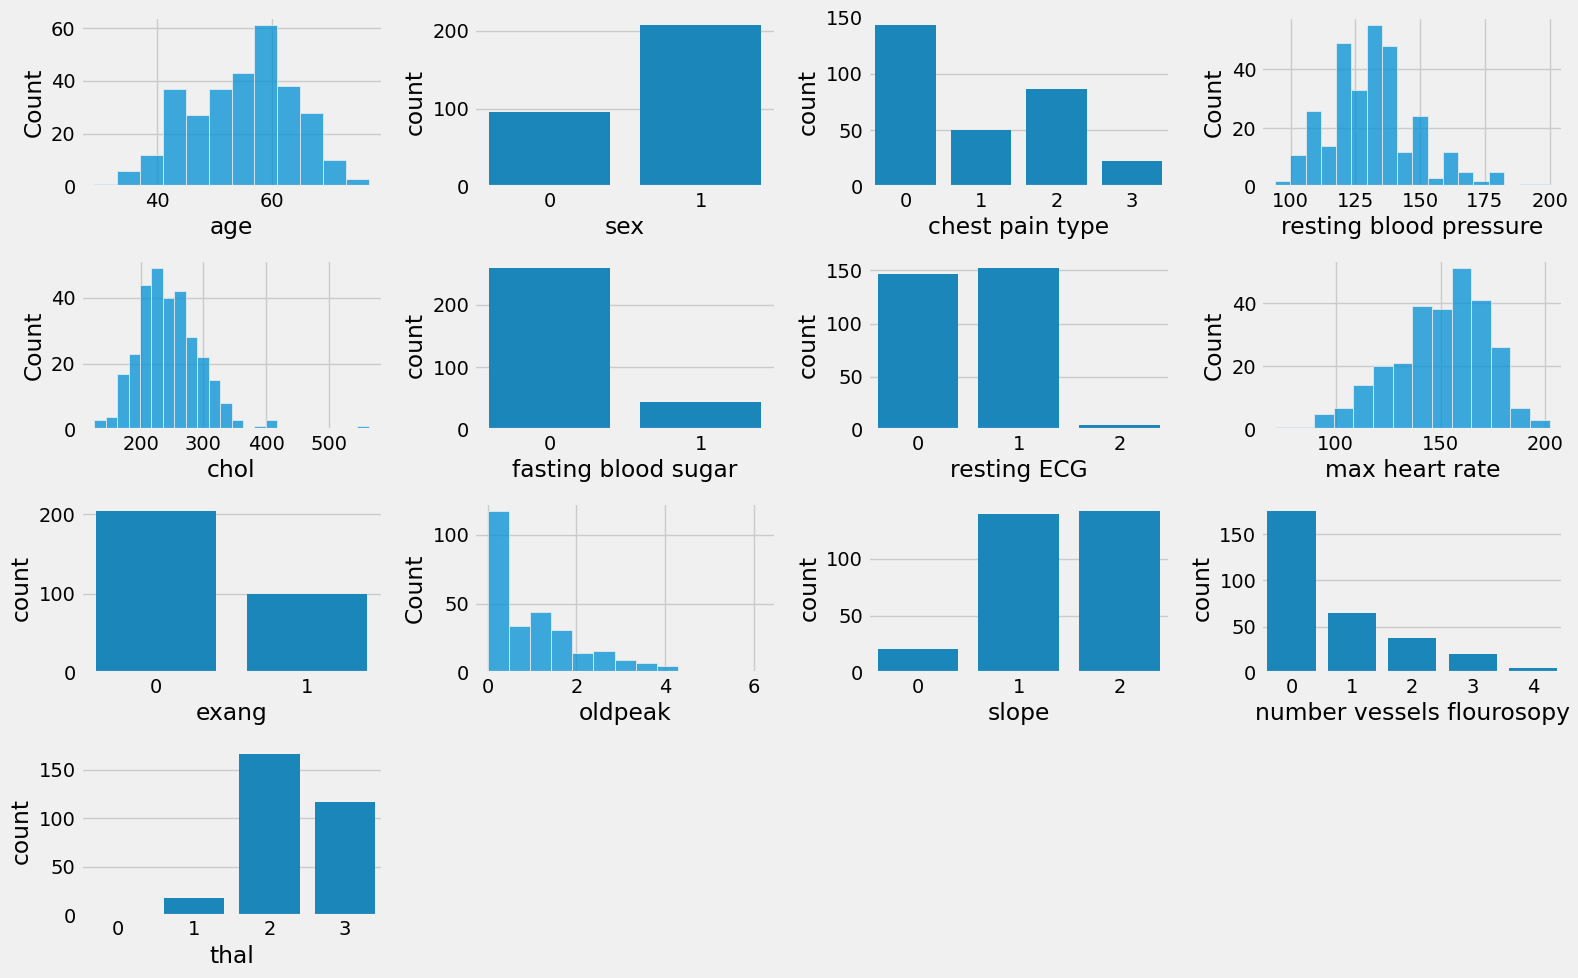

In [12]:
num_plots = len(df.columns) - 1  # Exclude the "target" column
num_rows = 4
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 10))

for i, col in enumerate(df.columns):
    if col != "target":
        ax = axes.flatten()[i]
        if col in categorical_feats:
            sns.countplot(data=df, x=col, ax=ax)
        elif col == "oldpeak":
            tmp_df = df[df["oldpeak"] >= 0]
            sns.histplot(data=tmp_df, x=col, ax=ax)
        else:
            sns.histplot(data=df, x=col, ax=ax)

# remove unused axes
for i in range(num_plots, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

fig.tight_layout()

plt.show()

Visualising the data by the target value:


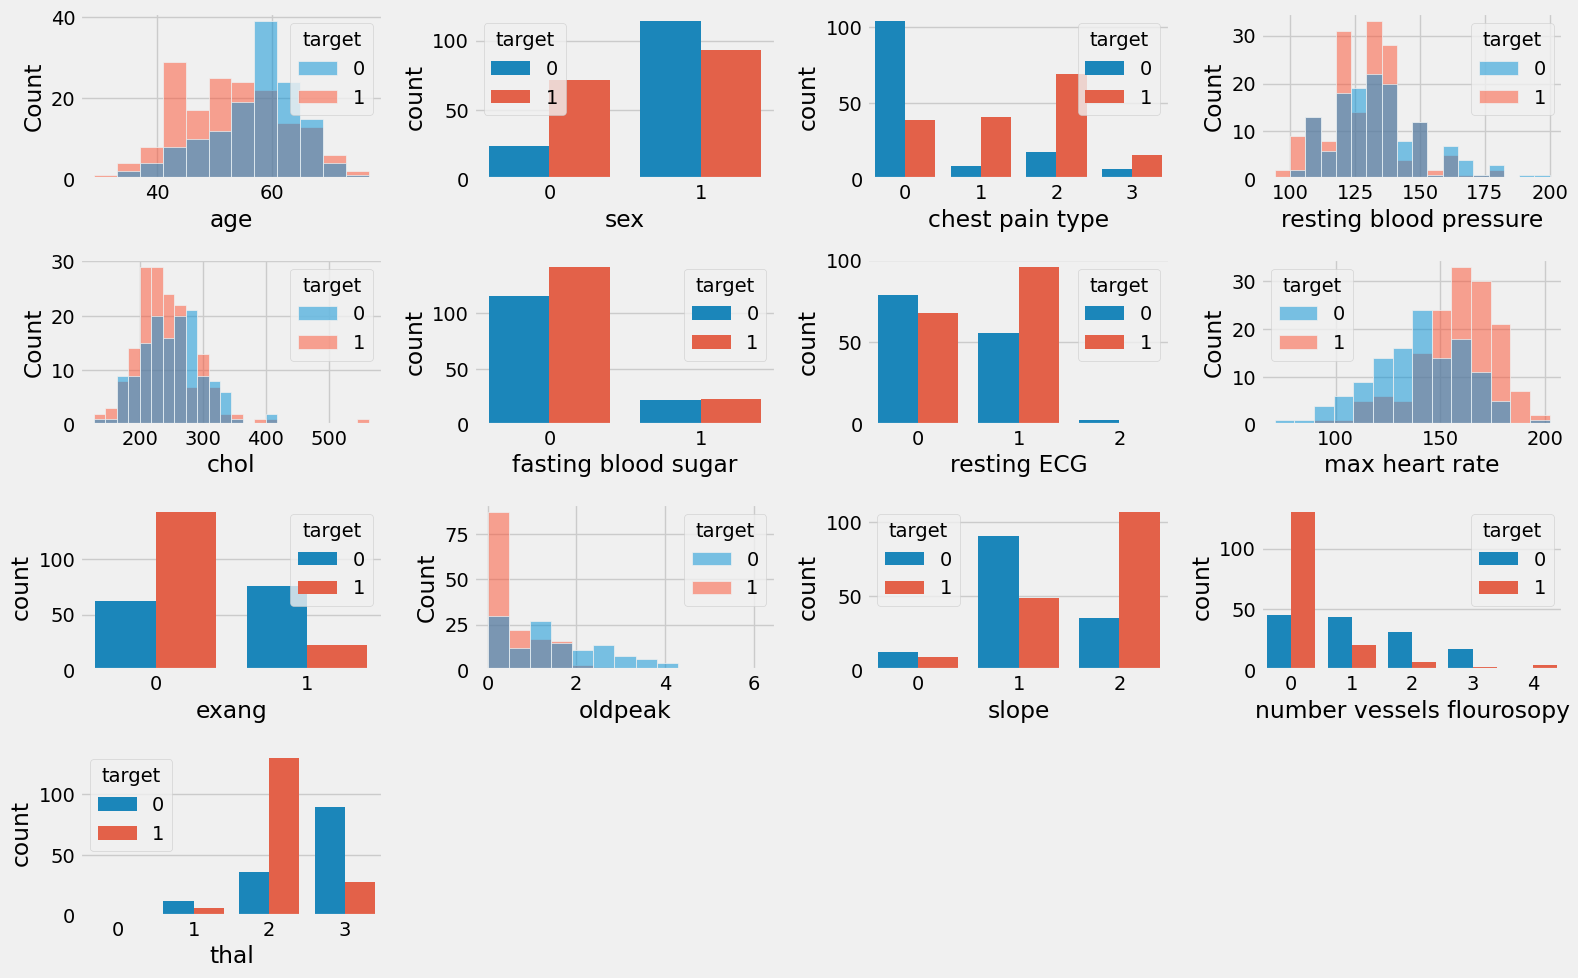

In [13]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 10))

for i, col in enumerate(df.columns):
    if col != "target":
        ax = axes.flatten()[i]
        if col in categorical_feats:
            sns.countplot(data=df, x=col, hue="target", ax=ax)
        elif col == "oldpeak":
            tmp_df = df[df["oldpeak"] >= 0]
            sns.histplot(data=tmp_df, x=col, hue="target", ax=ax)
        else:
            sns.histplot(data=df, x=col, hue="target", ax=ax)

# remove unused axes
for i in range(num_plots, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

fig.tight_layout()

plt.show()

Quick look at the correlation between the features:


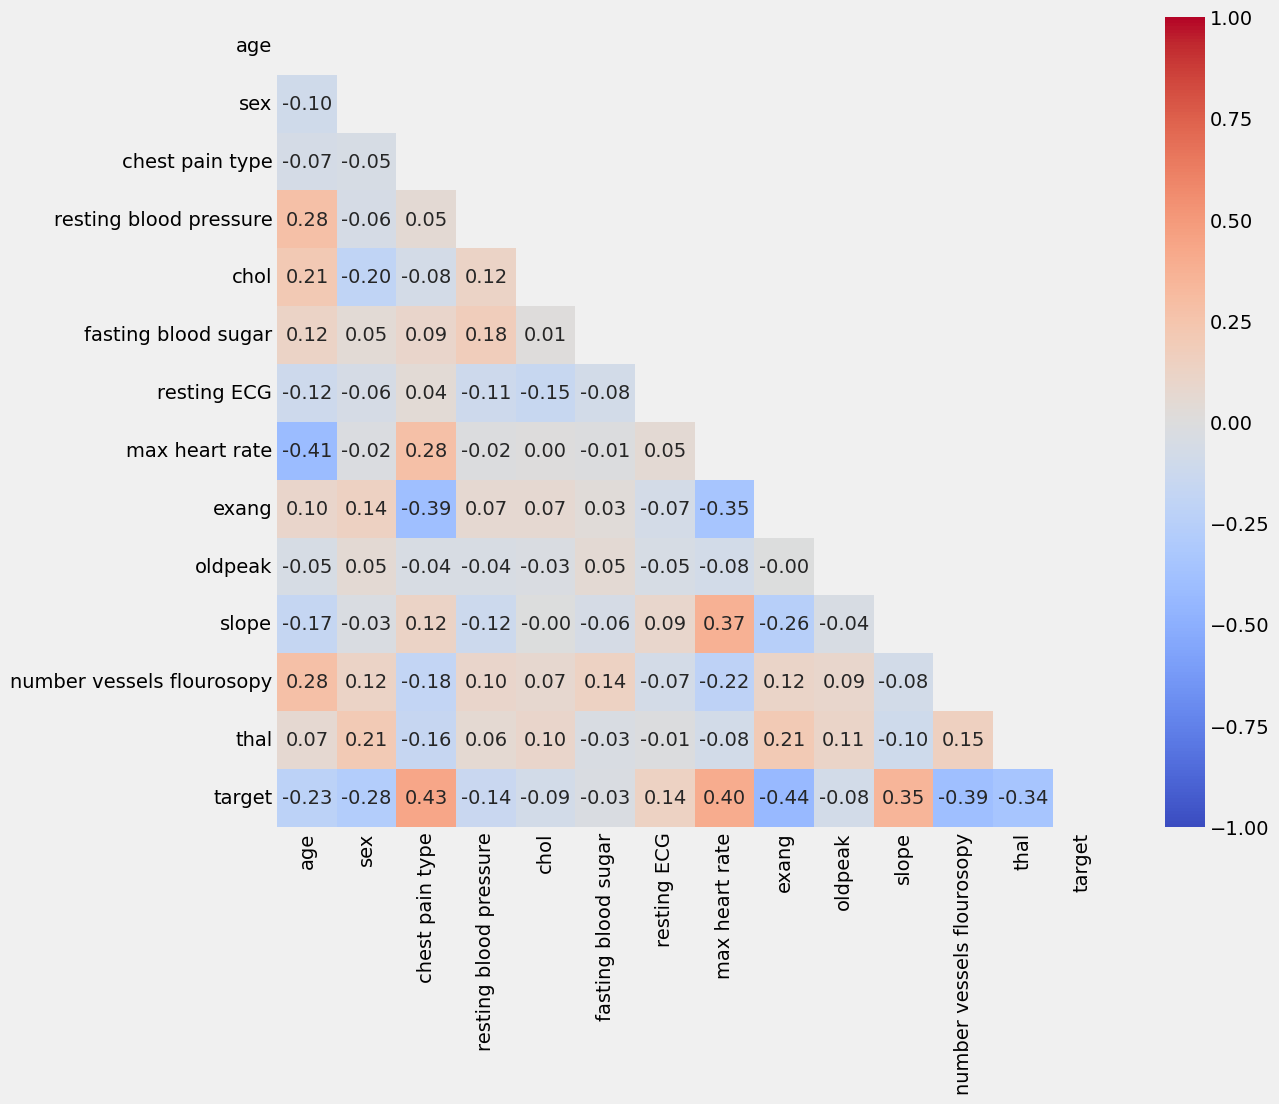

In [14]:
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    mask=np.triu(corr),  # mask the upper triangle
    fmt=".2f",
)
plt.grid(False)
plt.show()

Let's look at the `max heart rate` feature as it has missing values. It may be possible to fill in the missing values based on the other features - as there is probably some existing paramterisations of this feature.

Using the second to last approximation from the following [source](https://onlinelibrary.wiley.com/doi/10.1111/j.1600-0838.2012.01445.x).

![Max heart rate equations](img/max_heart_rate_equations.png)


<Axes: xlabel='age', ylabel='max heart rate'>

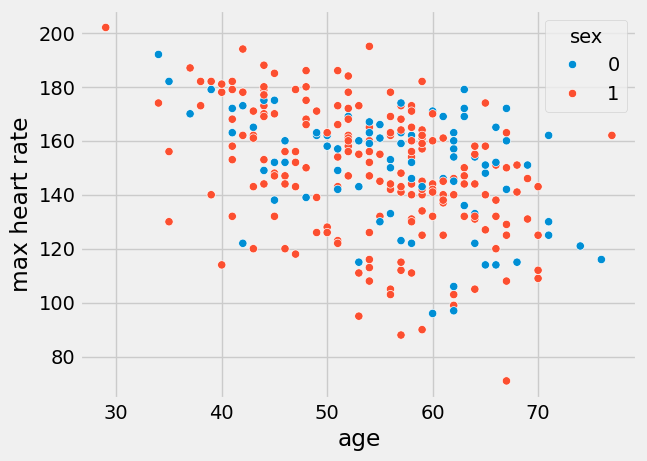

In [15]:
sns.scatterplot(data=df, x="age", y="max heart rate", hue="sex")

In [16]:
df["max heart rate"] = df["max heart rate"].fillna(211 - 0.64 * df["age"])

<Axes: xlabel='age', ylabel='max heart rate'>

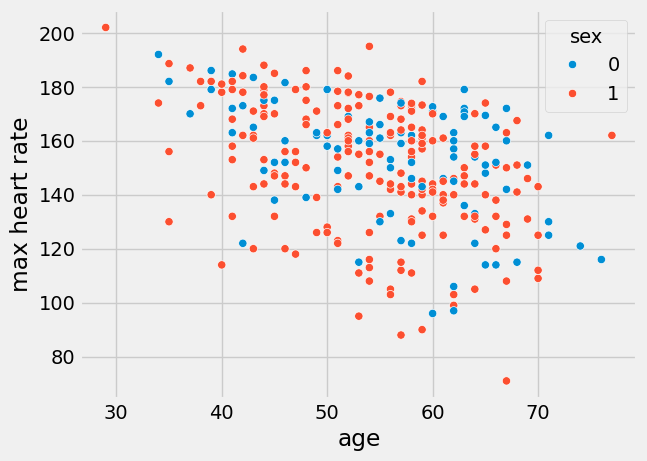

In [17]:
sns.scatterplot(data=df, x="age", y="max heart rate", hue="sex")

So, we could use this equation, however, this dataset is probably collected from a very different population than the one used in the study for this equation (patients with heart disease vs healthy sample). So, I will look at different ways to fill in the missing values later on.


# Data Schema


Using [Pandera](https://pandera.readthedocs.io/en/stable/) we can define a schema for the data, so that we can systematically validate the data before training the model. This will help later on when setting up the serving aspect of the model.


In [18]:
schema = pa.infer_schema(
    df
)  # See https://pandera.readthedocs.io/en/stable/schema_inference.html
schema.to_script("schema.py")

This will output something looking like this, to a python file:

```python
 from pandas import Timestamp
 from pandera import DataFrameSchema, Column, Check, Index, MultiIndex

 schema = DataFrameSchema(
     columns={
         "column1": Column(
             dtype="int64",
             checks=[
                 Check.greater_than_or_equal_to(min_value=5.0),
                 Check.less_than_or_equal_to(max_value=20.0),
             ],
             nullable=False,
             unique=False,
             coerce=False,
             required=True,
             regex=False,
             description=None,
             title=None,
         ),
     }, ...
 )
```

However, I want to use the [DataFrameModel](https://pandera.readthedocs.io/en/stable/dataframe_models.html) class instead so I can use it in a more object oriented way. (This is very similar to Pydantic)


In [19]:
class InputSchema(pa.DataFrameModel):
    # Can adjust checks and data types as needed

    age: Series[int] = pa.Field(ge=0)  # greater than or equal to 0
    cholesterol: Series[int] = pa.Field(ge=0, alias="chol")
    restingBloodPressure: Series[int] = pa.Field(ge=0, alias="resting blood pressure")

    oldPeak: Series[float] = pa.Field(
        alias="oldpeak"
    )  # could put ge=0 here instead to trigger a schema error earlier
    maxHeartRate: Series[float] = pa.Field(ge=0, nullable=True, alias="max heart rate")

    sex: Series[Category] = pa.Field(isin=[0, 1])
    chestPainType: Series[Category] = pa.Field(
        isin=[0, 1, 2, 3], alias="chest pain type"
    )
    fastingBloodSugar: Series[Category] = pa.Field(
        isin=[0, 1], alias="fasting blood sugar"
    )
    exang: Series[Category] = pa.Field(isin=[0, 1])
    slope: Series[Category] = pa.Field(isin=[0, 1, 2])
    thal: Series[Category] = pa.Field(isin=[0, 1, 2, 3])
    numberVesselsFlourosopy: Series[Category] = pa.Field(
        isin=[0, 1, 2, 3, 4],
        alias="number vessels flourosopy",
    )
    restingECG: Series[Category] = pa.Field(isin=[0, 1, 2], alias="resting ECG")

    target: Optional[Series[Category]] = pa.Field(isin=[0, 1])

    class Config:
        coerce = True  # will coerce the data types to the specified types


class OutputSchema(InputSchema):
    # Can add any new engineered features / any additional checks here

    oldPeak: Series[float] = pa.Field(
        ge=0, nullable=True, alias="oldpeak"
    )  # as we are replacing -99.99 values with NaN

We can use these schemas and the `check_types` decorator to validate functions that take use dataframes as input or output.
This is useful to ensure that the data is validated at every step of the pipeline.

In [20]:
@pa.check_types
def retrieve_data(path: Path) -> DataFrame[InputSchema]:
    return pd.read_csv(path)

In [21]:
@pa.check_types
def prepare_data(
    df: DataFrame[InputSchema], categorical_feats: List[str]
) -> DataFrame[OutputSchema]:
    # explicitly convert columns to categorical (even though Pandera will does this for us with the coerce=True flag)
    for col in categorical_feats:
        df[col] = df[col].astype("category")

    # replace -99.99 values with NaN, could also just replace all values < 0 with NaN
    df["oldpeak"] = df["oldpeak"].replace(-99.99, np.nan)
    return df

In [22]:
try:
    test_df = retrieve_data("data/heart.csv")
    transformed_df = prepare_data(test_df, categorical_feats)
    transformed_df = transformed_df.drop_duplicates()
except pa.errors.SchemaError as err:
    print(err)

In [23]:
test_df

,age,sex,chest pain type,resting blood pressure,chol,fasting blood sugar,resting ECG,max heart rate,exang,oldpeak,slope,number vessels flourosopy,thal,target
0,63,1,3,145,233,1,0,150.0,0,NaN,0,0,1,1
1,37,1,2,130,250,0,1,187.0,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,NaN,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178.0,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163.0,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123.0,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132.0,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141.0,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115.0,1,1.2,1,1,3,0


The `oldpeak` anomaly of -99.99 is now being replaced with NaN.

In [24]:
transformed_df

,age,sex,chest pain type,resting blood pressure,chol,fasting blood sugar,resting ECG,max heart rate,exang,oldpeak,slope,number vessels flourosopy,thal,target
0,63,1,3,145,233,1,0,150.0,0,NaN,0,0,1,1
1,37,1,2,130,250,0,1,187.0,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,NaN,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178.0,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163.0,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123.0,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132.0,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141.0,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115.0,1,1.2,1,1,3,0


The data types for the columns are also being converted to the correct types.

In [25]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        302 non-null    int64   
 1   sex                        302 non-null    category
 2   chest pain type            302 non-null    category
 3   resting blood pressure     302 non-null    int64   
 4   chol                       302 non-null    int64   
 5   fasting blood sugar        302 non-null    category
 6   resting ECG                302 non-null    category
 7   max heart rate             273 non-null    float64 
 8   exang                      302 non-null    category
 9   oldpeak                    279 non-null    float64 
 10  slope                      302 non-null    category
 11  number vessels flourosopy  302 non-null    category
 12  thal                       302 non-null    category
 13  target                     302 non-null 

# Model Training and Evaluation

First split the data into training and testing sets.

In [26]:
train_df, test_df = train_test_split(transformed_df, test_size=0.2, random_state=42)

In [27]:
def get_X_and_y(df: DataFrame[OutputSchema]) -> Tuple[pd.DataFrame, pd.Series]:
    X = df.drop(columns=["target"])
    y = df["target"]
    return X, y


X_train, y_train = get_X_and_y(train_df)
X_test, y_test = get_X_and_y(test_df)

Train an XGBoost model with the default parameters on the training data (containing the missing/null values).

In [28]:
eval_metric = "logloss"

xgb_model = XGBClassifier(
    random_state=42, enable_categorical=True, eval_metric=eval_metric
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

The xgboost model is overfitting the data, which is not a surprise given the default parameters relative to the size/complexity of the data, but will leave this as is for now. We could also consider using a simpler model, such as a logistic regression model, but the built in handling of missing values is useful for this case with XGBoost.

Some [parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters) to tune for the future to reduce overfitting:

- `colsample_bytree`: The ratio of columns (features) used, lower ratios avoid overfitting.
- `subsample`: The ratio of the training instances used (i.e. rows used), lower ratios avoid overfitting.
- `max_depth`: The maximum depth of a tree, lower values avoid overfitting.
- `eta`: The learning rate (how much to update our prediction with each successive tree), lower values avoid overfitting.
- `gamma`: The minimum loss reduction required to make a further split, larger values avoid overfitting.
- `min_child_weight`: The minimum sum of instance weight (or instances) needed in a leaf, karger values avoid overfitting.

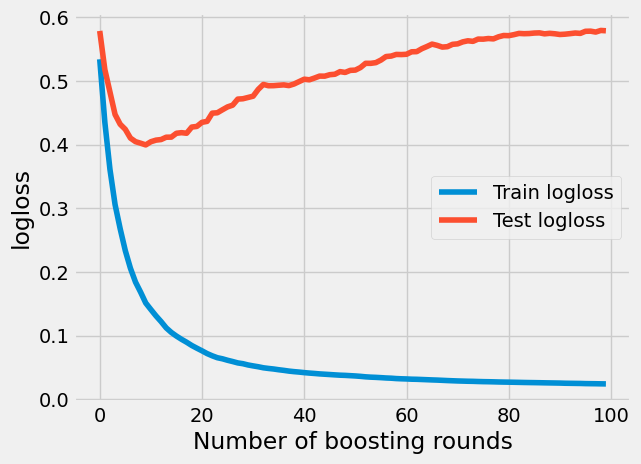

In [29]:
# visualise evaluation metric over number of boosting rounds
results = xgb_model.evals_result()

train_auc = results["validation_0"][eval_metric]
test_auc = results["validation_1"][eval_metric]

plt.plot(train_auc, label=f"Train {eval_metric}")
plt.plot(test_auc, label=f"Test {eval_metric}")

plt.xlabel("Number of boosting rounds")
plt.ylabel(eval_metric)
plt.legend()

plt.show()

Let's also try to estimate the performance of the model using cross validation, optimising using `recall` as the metric.
(As we are perhaps more concerned with false negatives than false positives in this case, as predicting a heart attack when there isn't one is less severe than not predicting one when there is one).

In [30]:
scores = cross_val_score(
    xgb_model, X_train, y_train, cv=5, scoring="recall"
)  # can change scoring depending on what we want to optimise for

print(
    f"Cross validation average recall score: {scores.mean():.2f} with a std dev of {scores.std():.2f}"
)

Cross validation average recall score: 0.86 with a std dev of 0.03


In [31]:
def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = (y_true == y_pred).mean()
    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

In [32]:
print(f"Performance on test set: {evaluate_model(y_test, xgb_model.predict(X_test))}")

Performance on test set: {'precision': 0.8888888888888888, 'recall': 0.75, 'f1': 0.8135593220338984, 'accuracy': 0.819672131147541}


Visualising the ROC curve:

AUC score: 0.89


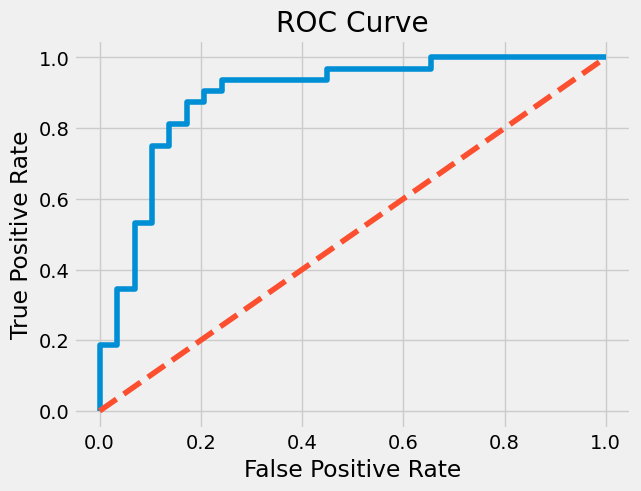

In [33]:
y_pred_proba = xgb_model.predict_proba(X_test)[
    :, 1
]  # get the probability of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
auc_score = np.trapz(tpr, fpr)
print(f"AUC score: {auc_score:.2f}")
plt.show()

Quick check of the feature importances. If we had many more features and we wanted to reduce the number of features to make serving the model easier we could use this information.

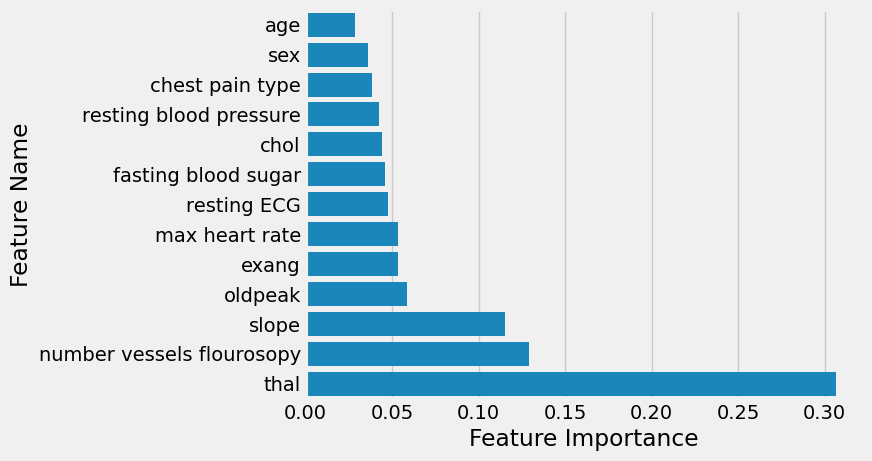

In [34]:
feature_importances = sorted(xgb_model.feature_importances_)
feature_names = X_train.columns
plt.figure()
sns.barplot(x=feature_importances, y=feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.show()

# Scikit-learn Pipeline

Now, I'll try a slightly different method where we preprocess the data, filling in missing values for `max heart rate` using the equation from earlier and using the median for `oldpeak`. Then training the model on this preprocessed data.

In [35]:
def fill_max_heart_rate(X: pd.DataFrame) -> np.ndarray:
    X["max heart rate"] = X["max heart rate"].fillna(211 - 0.64 * X["age"])

    # need to reshape to 2D array for ColumnTransformer
    return np.array(X["max heart rate"]).reshape(-1, 1)


column_transformer = ColumnTransformer(
    [
        (
            "max_heart_rate_imputer",
            FunctionTransformer(fill_max_heart_rate),
            ["age", "max heart rate"],
        ),
        (
            "oldpeak_imputer",
            SimpleImputer(strategy="median"),
            ["oldpeak"],
        ),
    ],
    remainder="passthrough",
)


pipe = Pipeline(
    [
        ("preprocessor", column_transformer),
        ("xgb_model", XGBClassifier(random_state=42, enable_categorical=True)),
    ]
)

In [36]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('max_heart_rate_imputer',
                                                  FunctionTransformer(func=<function fill_max_heart_rate at 0x177ff32e0>),
                                                  ['age', 'max heart rate']),
                                                 ('oldpeak_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['oldpeak'])])),
                ('xgb_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               cols...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [37]:
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="recall")
print(
    f"Cross validation average recall score: {scores.mean():.2f} with a std dev of {scores.std():.2f}"
)

Cross validation average recall score: 0.82 with a std dev of 0.03


In [38]:
print(f"Performance on test set: {evaluate_model(y_test, pipe.predict(X_test))}")

Performance on test set: {'precision': 0.84375, 'recall': 0.84375, 'f1': 0.84375, 'accuracy': 0.8360655737704918}


The CV results for just xgboost vs preprocessing and xgboost are in range of each other, but the preprocessing and xgboost method performs better on the (separate) test set.

## Pipeline with KNNImputer

We can also try a slightly more advanced method for imputing missing values (for any column/feature) using `KNNImputer` from scikit-learn. This method uses the k-nearest neighbours to fill in the missing values.

In [39]:
# change pipeline to use a knn imputer
pipe = Pipeline(
    [
        ("preprocessor", KNNImputer()),
        ("xgb_model", XGBClassifier(random_state=42, enable_categorical=True)),
    ]
)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', KNNImputer()),
                ('xgb_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [40]:
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="recall")
print(
    f"Cross validation average recall score: {scores.mean():.2f} with a std dev of {scores.std():.2f}"
)
print(f"Performance on test set: {evaluate_model(y_test, pipe.predict(X_test))}")

Cross validation average recall score: 0.87 with a std dev of 0.05
Performance on test set: {'precision': 0.8666666666666667, 'recall': 0.8125, 'f1': 0.8387096774193549, 'accuracy': 0.8360655737704918}


The results are broadly in line with the previous methods. We can also try using the pipeline with random/grid search to tune the KNNImputer hyperparameters (or any other hyperparameters in the pipeline).

In [41]:
param_distributions = {"preprocessor__n_neighbors": [1, 3, 5, 7, 9]}

search = GridSearchCV(
    pipe,
    param_grid=param_distributions,
    cv=5,
    scoring="recall",
)

search.fit(X_train, y_train)

print(f"Best found params: {search.best_params_}")
pipe = search.best_estimator_

# get average cv score for best model
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="recall")
print(
    f"Cross validation average recall score: {scores.mean():.2f} with a std dev of {scores.std():.2f}"
)
print(f"Performance on test set: {evaluate_model(y_test, pipe.predict(X_test))}")

Best found params: {'preprocessor__n_neighbors': 7}
Cross validation average recall score: 0.88 with a std dev of 0.07
Performance on test set: {'precision': 0.8709677419354839, 'recall': 0.84375, 'f1': 0.8571428571428571, 'accuracy': 0.8524590163934426}


In [42]:
pipe

Pipeline(steps=[('preprocessor', KNNImputer(n_neighbors=7)),
                ('xgb_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Let's save the model using pickle, and test loading it back in.

In [43]:
with open("pipeline.pkl", "wb") as f:
    pickle.dump(pipe, f)

In [44]:
# test loading the pipeline
with open("pipeline.pkl", "rb") as f:
    loaded_pipe = pickle.load(f)

# Check that the loaded pipeline works as expected
print(f"Performance on test set: {evaluate_model(y_test, pipe.predict(X_test))}")

Performance on test set: {'precision': 0.8709677419354839, 'recall': 0.84375, 'f1': 0.8571428571428571, 'accuracy': 0.8524590163934426}


In [45]:
# see what happens if we use the pipeline with a single row of data which has missing values
single_example = X_test[X_test.isnull().any(axis=1)].iloc[0:1]
single_example

,age,sex,chest pain type,resting blood pressure,chol,fasting blood sugar,resting ECG,max heart rate,exang,oldpeak,slope,number vessels flourosopy,thal
5,57,1,0,140,192,0,1,148.0,0,NaN,1,0,1


In this example the missing value for `oldpeak` is filled with 1.05714286

In [46]:
print(loaded_pipe["preprocessor"].transform(single_example))

[[ 57.           1.           0.         140.         192.
    0.           1.         148.           0.           1.05714286
    1.           0.           1.        ]]


The downside of using KNNImputer is that it is computationally expensive, especially with a large dataset.
Saving the pipeline with pickle will also mean saving a version of the training data used for the KNNImputer, which may not be ideal depending on the size of the dataset.

In [47]:
len(loaded_pipe["preprocessor"]._fit_X)

241

# Saving model

For now, will just focus on serving the original XGBoost model without the preprocessing steps in the scikit-learn pipelines.

In [48]:
with open("model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

In [49]:
# again, test loading the model
with open("model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

y_pred = loaded_model.predict(X_test)
print(evaluate_model(y_test, y_pred))

{'precision': 0.8888888888888888, 'recall': 0.75, 'f1': 0.8135593220338984, 'accuracy': 0.819672131147541}
